In [1]:
#pip install dask
#pip install metpy
#!pip install seaborn
# !pip install plotly
# !pip install pyarrow

In [2]:
#import necessary libraries
import xarray as xr
from glob import glob
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from netCDF4 import Dataset
from scipy.constants import g
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy.spatial import KDTree
from sklearn.utils import resample
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score


# Load in ERA5 Data and Derive Necessary Parameters

In [3]:
#LOAD AND MERGE ALL 2024 DATASETS

#Find all files for 2024
base_dir = '/users/janesharai/desktop/era5_2024'
variables = ['geopotential_height', 'temp', 'uwind', 'vwind', 'specific_humidity', 'RH', 'CAPE', 'CIN', 'convective_precip', 'convective_rainrate', 'k_index', 'total_column_rain_water', 'precip_type', '2m_temp', '2m_td']

# Create a dictionary of datasets
ds_dict = {}
for var in variables:
    files = glob(f"{base_dir}/{var}_2024*.nc")
    ds_dict[var] = xr.open_mfdataset(files, combine='by_coords')

# Merge all variables into one dataset
ds = xr.merge([
    ds_dict['geopotential_height'].rename({'z': 'geopotential_height'}),
    ds_dict['temp'].rename({'t': 'temp'}),
    ds_dict['uwind'].rename({'u': 'u_wind'}),
    ds_dict['vwind'].rename({'v': 'v_wind'}),
    ds_dict['specific_humidity'].rename({'q': 'specific_humidity'}),
    ds_dict['RH'].rename({'r': 'relative_humidity'}),
    ds_dict['CAPE'].rename({'cape': 'CAPE'}), #surface based CAPE
    ds_dict['CIN'].rename({'cin': 'CIN'}),
    ds_dict['convective_precip'].rename({'cp': 'convective_precip'}), 
    ds_dict['convective_rainrate'].rename({'crr': 'convective_rainrate'}),
    ds_dict['k_index'].rename({'kx': 'k_index'}),
    ds_dict['total_column_rain_water'].rename({'tcrw': 'total_column_rain_water'}),
    ds_dict['precip_type'].rename({'ptype': 'precip_type'}),
    ds_dict['2m_temp'].rename({'t2m': '2m_temp'}),
    ds_dict['2m_td'].rename({'d2m': '2m_td'})
])

print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:                  (valid_time: 8784, pressure_level: 4,
                              latitude: 21, longitude: 66)
Coordinates:
  * valid_time               (valid_time) datetime64[ns] 70kB 2024-01-01 ... ...
  * pressure_level           (pressure_level) float64 32B 1e+03 850.0 ... 500.0
  * latitude                 (latitude) float64 168B 54.0 53.75 ... 49.25 49.0
  * longitude                (longitude) float64 528B -118.0 -117.8 ... 250.0
    number                   int64 8B 0
    expver                   (valid_time) <U4 141kB dask.array<chunksize=(8784,), meta=np.ndarray>
Data variables: (12/15)
    geopotential_height      (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    temp                     (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    u_wind                   (valid_time, pressure_le

In [4]:
#PRE-PROCESS THE DATA -- add units

# Assign CRS and units
ds = ds.metpy.assign_crs(grid_mapping_name="latitude_longitude")

# Add units to the variables
ds['temp'].attrs['units'] = 'K'
ds['u_wind'].attrs['units'] = 'm/s'
ds['v_wind'].attrs['units'] = 'm/s'
ds['specific_humidity'].attrs['units'] = 'kg/kg'
ds['pressure_level'].attrs['units'] = 'hPa'
ds['relative_humidity'].attrs['units'] = '%'
ds['geopotential_height'].attrs['units'] = 'm'
ds['CAPE'].attrs['units'] = 'J/kg'
ds['CIN'].attrs['units'] = 'J/kg'
ds['convective_precip'].attrs['units'] = 'm' 
ds['convective_rainrate'].attrs['units'] = 'kg/m^2*s'
ds['k_index'].attrs['units'] = 'K'
ds['total_column_rain_water'].attrs['units'] = 'kg/m^2'


ds

<xarray.Dataset> Size: 2GB
Dimensions:                  (valid_time: 8784, pressure_level: 4,
                              latitude: 21, longitude: 66)
Coordinates:
  * valid_time               (valid_time) datetime64[ns] 70kB 2024-01-01 ... ...
  * pressure_level           (pressure_level) float64 32B 1e+03 850.0 ... 500.0
  * latitude                 (latitude) float64 168B 54.0 53.75 ... 49.25 49.0
  * longitude                (longitude) float64 528B -118.0 -117.8 ... 250.0
    number                   int64 8B 0
    expver                   (valid_time) <U4 141kB dask.array<chunksize=(8784,), meta=np.ndarray>
    metpy_crs                object 8B Projection: latitude_longitude
Data variables: (12/15)
    geopotential_height      (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    temp                     (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    u_wind                   (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    v_wind                   (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    specific_humidity        (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    relative_humidity        (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    ...                       ...
    convective_rainrate      (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(4392, 11, 16), meta=np.ndarray>
    k_index                  (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(4392, 11, 16), meta=np.ndarray>
    total_column_rain_water  (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(4392, 11, 16), meta=np.ndarray>
    precip_type              (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(4392, 11, 16), meta=np.ndarray>
    2m_temp                  (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(4392, 11, 16), meta=np.ndarray>
    2m_td                    (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(4392, 11, 16), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-24T08:19 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
# Define Constants

Rd = 287.05  # J/(kg·K) - specific gas constant for dry air
epsilon = 0.622  # Ratio of gas constants for dry air and water vapor
g = 9.81  # Gravitational acceleration (m/s^2)
Rd = 287.05  # Gas constant for dry air (J/kg·K)
Cp = 1005  # Specific heat at constant pressure (J/kg·K)
gamma_d = g / Cp  # Dry adiabatic lapse rate ≈ 0.0098 K/m

dry_ad_lapse_rate = 9.8 / 1000  # °C/m
moist_ad_lapse_rate = 6 / 1000  # °C/m
g0 = 9.80665  # m/s² (standard gravitational acceleration)

In [6]:
# Extract terms, keeping them as an xarray.DataArray to preserve metadata

pressure_Pa = ds['pressure_level'] * 100  # hPa → Pa 
pressure_hPa = ds['pressure_level']  # hPa 
pressure_kPa = pressure_Pa / 1000  # Pa → kPa
temperature_K = ds['temp']  # K
temperature_C = temperature_K - 273.15  # °C
geopotential = ds['geopotential_height']  # meters 
height_m = geopotential / g0  # meters
height_km = height_m / 1000  # km
u_wind = ds['u_wind']  # m/s
v_wind = ds['v_wind']  # m/s
relative_humidity = ds['relative_humidity']  # %
q = ds['specific_humidity']  # kg/kg 
t_surface_K = ds['temp'].sel(pressure_level=1000, method='nearest') # K
t_surface_C = t_surface_K - 273.15  # °C
two_m_temp_K = ds['temp']  # K
two_m_temp_C = two_m_temp_K - 273.15  # °C

two_m_td_K = ds['2m_td']  # K
two_m_td_C = two_m_td_K - 273.15  # °C

CAPE = ds['CAPE']  # J/kg
CIN = ds['CIN']  # J/kg
convective_precip = ds['convective_precip']  # m
convective_rainrate = ds['convective_rainrate']  # kg/m²*s
k_index = ds['k_index']  # K
total_column_rain_water = ds['total_column_rain_water']  # kg/m²
precip_type = ds['precip_type']  # kg

In [7]:
# Calculate mixing ratio -->  w = q / (1 - q")
mixing_ratio = q / (1 - q)

#assign units
mixing_ratio.attrs['units'] = 'kg/kg'

#add as variable to ds
ds = ds.assign(mixing_ratio=mixing_ratio)

In [8]:
#Calculate dew point temperature
eo = 0.6113 #kPa
To = 273.15 #K
Rv_Lv = 1.844E-4 #K^-1


T_dp_K = ((1/To) - (Rv_Lv * np.log(mixing_ratio*pressure_kPa/(eo*(mixing_ratio+epsilon)))))**-1
T_dp_C = T_dp_K - 273.15


#assign units
T_dp_C.attrs['units'] = 'C'
T_dp_K.attrs['units'] = 'K'

#add as variable to ds
ds = ds.assign(T_dp_C=T_dp_C)
ds = ds.assign(T_dp_K=T_dp_K)

In [9]:
#calculate vapour pressure (e)
e = eo*np.exp(Rv_Lv*((1/To) - (1/T_dp_K)))

#assign units
e.attrs['units'] = 'kPa'

#add as variable to ds
ds = ds.assign(e=e)

In [10]:
#Calculate most unstable CAPE
Lv = 2.5e6   # Latent heat of vaporization [J/kg]
cp = 1005     # Specific heat of air [J/kg·K]
Rd = 287      # Gas constant for dry air [J/kg·K]


# Select lowest 300 hPa (most unstable layer)
pressure_mask = ds['pressure_level'] >= (ds['pressure_level'].max() - 300)
pres = ds['pressure_level'].where(pressure_mask)
temp = ds['temp'].where(pressure_mask) #K 
dewpoint = ds['T_dp_K'].where(pressure_mask) #K

theta_e = temp * (1000 / pres)**0.286 * np.exp(Lv * mixing_ratio / (cp * temp))
theta_e_filled = theta_e.fillna(-1e10)

# Find most unstable parcel (max θₑ)
mu_index = theta_e_filled.argmax(dim='pressure_level').compute()
mu_pres = pres.isel(pressure_level=mu_index).compute()
mu_temp = temp.isel(pressure_level=mu_index)
mu_dewpoint = dewpoint.isel(pressure_level=mu_index)

# Initialize CAPE array
MUCAPE = xr.zeros_like(mu_temp)

for i in range(len(ds['pressure_level'])):
    p = ds['pressure_level'][i]
    t_env = ds['temp'].isel(pressure_level=i)
    
    # Create mask for dry vs moist ascent
    dry_mask = (p >= mu_pres)
    
    # Calculate parcel temperature
    t_parcel = xr.where(
        dry_mask,
        mu_temp * (p / mu_pres)**0.286,  # Dry adiabatic
        mu_temp * (p / mu_pres)**0.286    
    )
    
    # CAPE contribution
    cape_contribution = Rd * (t_parcel - t_env) * np.log(ds['pressure_level'][i-1]/ds['pressure_level'][i]) if i > 0 else 0
    MUCAPE += xr.where(t_parcel > t_env, cape_contribution, 0)


#add to ds
ds = ds.assign(MUCAPE=MUCAPE)

In [11]:
#Calculate LCL

a = 0.125 #km/C°

LCL_km= (temperature_C - T_dp_C) * a  # LCL in km
LCL_m = LCL_km * 1000  # LCL in meters

#add units
LCL_km.attrs['units'] = 'km'
LCL_m.attrs['units'] = 'm'

#add as variable to ds
ds = ds.assign(LCL_km=LCL_km)
ds = ds.assign(LCL_m=LCL_m)


In [12]:
# Calculate temperature at LCL
temp_at_LCL = t_surface_C - (dry_ad_lapse_rate * LCL_m)

# Add units
temp_at_LCL.attrs['units'] = 'K'

# Add as variable to ds
ds = ds.assign(temp_at_LCL=temp_at_LCL)

# -------------------------------------------------------------------------------------

# Extract geopotential height at 50 kPa
pressure_50kPa = 50.0  # kPa
height_to_50kPa = geopotential.sel(pressure_level=pressure_50kPa, method='nearest')

# Convert geopotential height to actual height
actual_height_to_50kPa = height_to_50kPa / g0

# Calculate temperature at 50 kPa level
temp_at_50kPa = temp_at_LCL - moist_ad_lapse_rate * (actual_height_to_50kPa - LCL_m)

# Calculate Lifted Index
LI = temp_at_LCL - temp_at_50kPa #°C

# Add units
LI.attrs['units'] = '°C'

# Add as variable to ds
ds = ds.assign(LI=LI)

In [13]:
#calculate effective layer bulk shear

#constants set
surface_pressure = 1000.0  # hPa
effective_layer_pressure = 850.0  

# Extract U and V wind components
u_surface = ds['u_wind'].sel(pressure_level=surface_pressure, method='nearest')
v_surface = ds['v_wind'].sel(pressure_level=surface_pressure, method='nearest')

u_eff = ds['u_wind'].sel(pressure_level=effective_layer_pressure, method='nearest')
v_eff = ds['v_wind'].sel(pressure_level=effective_layer_pressure, method='nearest')

# Calculate bulk shear
bulk_shear = np.sqrt((u_eff - u_surface)**2 + (v_eff - v_surface)**2)

# Assign units 
bulk_shear.attrs['units'] = 'm/s'

# Add as variable to ds
ds = ds.assign(bulk_shear=bulk_shear)

In [14]:

# Constants
dry_ad_lapse_rate = 9.8 / 1000  # Dry adiabatic lapse rate (°C/m)
moist_ad_lapse_rate = 6 / 1000  # Moist adiabatic lapse rate (°C/m)
g0 = 9.80665  # Gravitational acceleration (m/s²)

# Calculate the temperature of the air parcel at LCL
T_surface = ds['temp'].sel(pressure_level=1000, method='nearest')  # Surface temperature at 1000 hPa (K)
T_parcel_LCL = T_surface - (dry_ad_lapse_rate * LCL_m)

# Calculate parcel temperature at each level after LCL using the moist adiabatic lapse rate
for level in range(len(pressure_hPa)):  # Loop through pressure levels
    # Extract environmental temperature
    T_env = temperature_K.isel(valid_time=0, pressure_level=level) 

    # Extract geopotential height at this pressure level
    height_at_level = geopotential.isel(valid_time=0, pressure_level=level) / g0  # Convert to meters

    # Calculate parcel temperature at this level using moist adiabatic lapse rate
    condition = height_at_level > LCL_m 

    T_parcel = T_parcel_LCL.where(~condition, T_parcel_LCL - moist_ad_lapse_rate * (height_at_level - LCL_m))  # Apply moist adiabatic lapse rate

    # Check if the parcel temperature equals the environmental temperature
    equilibrium_level = (T_parcel <= T_env) & condition 

    # Extract the equilibrium level where the condition is true
    if equilibrium_level.any(): 
        # Extract the height at which equilibrium is reached
        EL = height_at_level.where(equilibrium_level.any(), drop=True)
        break

# Add units
EL.attrs['units'] = 'm'

# Add as variable to ds
ds = ds.assign(EL=EL)

In [15]:
#calculate freezing level height

# define condition
freezing_condition = (temperature_C <= 0).compute()

# Extract the height where the temperature crosses 0°C
freezing_level_height = height_m.where(freezing_condition, drop=True)

# Add units
freezing_level_height.attrs['units'] = 'm'

# Add as variable to ds
ds = ds.assign(freezing_level_height=freezing_level_height)

In [16]:
# calculate LR
CAPE_filter = MUCAPE.clip(min=201, max=4000)
BS_filter = bulk_shear.clip(min=11, max=27)
FL_filter = freezing_level_height.clip(min=500, max=4000)
LCL_m_filter = LCL_m.clip(min=500, max=1500)


T_500 = temperature_C.sel(pressure_level=500, method='nearest')
T_800 = temperature_C.sel(pressure_level=800, method='nearest')

H_500 = height_km.sel(pressure_level=500, method='nearest') #km
H_800 = height_km.sel(pressure_level=800, method='nearest') #km

LR = (T_800 - T_500) / ((H_500 - H_800))  # 500–800 hPa temperature lapse rate [C°/km]

#add units
LR.attrs['units'] = 'C/km'

#add as variable to ds
ds = ds.assign(LR=LR) 

# -----------------------------------------

# Clip LR between 5 and 8
LR = xr.where(LR < 5, 5, LR)
LR = xr.where(LR > 8, 8, LR)

# Calculate HSI
HSI = (
    (np.sqrt(10 * (CAPE_filter - 200)) * (BS_filter - 5) * (7000 - FL_filter + LCL_m_filter)) / 194000
) * np.sqrt((EL * (LR - 4)**2) / 10000000)


#add as variable to ds
ds = ds.assign(HSI=HSI)


In [17]:
#calculate large hail index (LGHail)

# Find most unstable level
pressure_mask = ds['pressure_level'] >= (ds['pressure_level'].max() - 300)
masked_temp = ds['temp'].where(pressure_mask)
masked_pres = ds['pressure_level'].where(pressure_mask)


# Calculate theta_e only for masked levels
theta_e = masked_temp * (1000 / masked_pres)**0.286
theta_e_filled = theta_e.fillna(-1e10)
mu_index = theta_e_filled.argmax(dim='pressure_level').compute()
mu_pressure = theta_e_filled.argmax(dim='pressure_level').compute()


# Get parcel properties as numpy arrays
mu_T_parcel = temperature_K.isel(pressure_level=mu_index).values  
mu_Td_parcel = T_dp_K.isel(pressure_level=mu_index).values

# Find -10°C level 
minus10_idx = (temperature_C <= -10).argmax(dim='pressure_level').compute()
env_temp_minus10 = temperature_K.isel(pressure_level=minus10_idx).values

LI_10K = env_temp_minus10 - mu_T_parcel  # T_env - T_parcel
LI_10C = LI_10K - 273.15  # Convert to °C

#Calculate updraft 
updraft = (1 + (bulk_shear/20))*(-LI_10C)

# Bolton formula for LCL temp (K)
unstable_LCL_temp_K = (1 / (1 / (mu_Td_parcel - 56) + np.log(mu_T_parcel / mu_Td_parcel) / 800)) + 56
unstable_LCL_temp_C = unstable_LCL_temp_K - 273.15  # Convert to °C

#calculate ice
ice = 1 - (1 / (1 + ((10*updraft)/(unstable_LCL_temp_C**2))))

#convert mixing ratio to g/kg
MU_MR = mixing_ratio.isel(pressure_level=mu_pressure) * 1000 #g/kg

LGHail = ice*MU_MR*0.5*(1 + np.sqrt(updraft/10))

#add as variable to ds
ds = ds.assign(LGHail=LGHail)

In [18]:
#Calculate Significant Hail Parameter (SHP)

MU_MR_bounded = MU_MR.clip(11, 13.6)  # SHIP bounds

#2. Calculate LR 
T_700 = temperature_K.sel(pressure_level=700)
T_500 = temperature_K.sel(pressure_level=500)
Z_700 = geopotential.sel(pressure_level=700)
Z_500 = geopotential.sel(pressure_level=500)

LR = ((T_700 - T_500) / (Z_500 - Z_700)) * 1000  # Convert to K/km

# Temp at 500 hPa
T_500hPa = temperature_C.sel(pressure_level=500)
T_500hPa_bounded = T_500hPa.where(T_500hPa <= -5, -5)  # Cap at -5°C if warmer

# Calculate 0-6 km AGL bulk shear

# Extract wind components (u = eastward, v = northward)
u_sfc = ds['u_wind'].sel(pressure_level=ds['pressure_level'].max())  # Surface
v_sfc = ds['v_wind'].sel(pressure_level=ds['pressure_level'].max())
u_500 = ds['u_wind'].sel(pressure_level=500)  # 500 hPa (~5.5 km)
v_500 = ds['v_wind'].sel(pressure_level=500)

# Compute bulk shear magnitude
bulk_shear_0to6 = np.sqrt((u_500 - u_sfc)**2 + (v_500 - v_sfc)**2)
bulk_shear_0to6 = bulk_shear.clip(7, 27)  # Apply SHIP bounds 

# Base SHIP
SHIP = (MUCAPE * MU_MR * LR * (-T_500) * bulk_shear_0to6) / 42_000_000

# Adjustments based on formula
SHIP = SHIP * xr.where(MUCAPE < 1300, MUCAPE / 1300, 1)  # CAPE adjustment
SHIP = SHIP * xr.where(LR < 5.8, LR / 5.8, 1)        # LR adjustment
SHIP = SHIP * xr.where(freezing_level_height < 2400, freezing_level_height / 2400, 1) 

#add as variable to ds
ds = ds.assign(SHIP=SHIP)

In [19]:
#calculate superceel composite parameter 

# Extract winds at standard pressure levels (replace with your actual level indices)
u_sfc = ds['u_wind'].sel(pressure_level=1000, method='nearest')  # Surface
v_sfc = ds['v_wind'].sel(pressure_level=1000, method='nearest')

u_1km = ds['u_wind'].sel(pressure_level=850, method='nearest')   # ~1.5 km
v_1km = ds['v_wind'].sel(pressure_level=850, method='nearest')

u_3km = ds['u_wind'].sel(pressure_level=700, method='nearest')   # ~3 km
v_3km = ds['v_wind'].sel(pressure_level=700, method='nearest')

u_6km = ds['u_wind'].sel(pressure_level=500, method='nearest')   # ~5.5 km
v_6km = ds['v_wind'].sel(pressure_level=500, method='nearest')

# Calculate storm motion (mean 0–6 km wind)
u_mean = (u_sfc + u_1km + u_3km + u_6km) / 4
v_mean = (v_sfc + v_1km + v_3km + v_6km) / 4

# Compute 0–3 km SRH
srh_layer1 = -((u_sfc - u_mean) * (v_1km - v_sfc) - (v_sfc - v_mean) * (u_1km - u_sfc))
srh_layer2 = -((u_1km - u_mean) * (v_3km - v_1km) - (v_1km - v_mean) * (u_3km - u_1km))
SRH03 = srh_layer1 + srh_layer2
SRH_eff = SRH03 * 0.8  # scaling

# Compute effective bulk shear (0–6 km)
BS_eff = xr.where(bulk_shear_0to6 > 20, 1, xr.where(bulk_shear_0to6 < 10, 0, bulk_shear_0to6 / 20))

# Calculate SCP
SCP = (MUCAPE / 1000) * (SRH_eff / 50) * BS_eff

#add as variable to ds
ds = ds.assign(SCP=SCP)

In [20]:
#calculate Wmaxshear MU
Wmaxshear_MU = np.sqrt(2*MUCAPE) * bulk_shear_0to6
#add as variable to ds
ds = ds.assign(Wmaxshear_MU=Wmaxshear_MU)


#calculate Wmaxshear eff
Wmaxshear_eff = np.sqrt(2*MUCAPE) * bulk_shear
#add as variable to ds
ds = ds.assign(Wmaxshear_eff=Wmaxshear_eff)

In [21]:
#add temperature at 500 hPa as a variable
T_500 = temperature_C.sel(pressure_level=500, method='nearest')
#add units
T_500.attrs['units'] = 'C'
#add as variable to ds
ds = ds.assign(T_500=T_500)

#add temperature at 700 hPa as a variable
T_700 = temperature_C.sel(pressure_level=700, method='nearest')
#add units
T_700.attrs['units'] = 'C'
#add as variable to ds
ds = ds.assign(T_700=T_700)

# -----------------------------------------

#add dew temperature at 500 hPa as a variable
T_dp_500 = T_dp_C.sel(pressure_level=500, method='nearest')
#add units
T_dp_500.attrs['units'] = 'C'
#add as variable to ds
ds = ds.assign(T_dp_500=T_dp_500)

#add dew temperature at 700 hPa as a variable
T_dp_700 = T_dp_C.sel(pressure_level=700, method='nearest')
#add units
T_dp_700.attrs['units'] = 'C'
#add as variable to ds
ds = ds.assign(T_dp_700=T_dp_700)

#add dew temperature at 850 hPa as a variable
T_dp_850 = T_dp_C.sel(pressure_level=850, method='nearest')
#add units
T_dp_850.attrs['units'] = 'C'
#add as variable to ds
ds = ds.assign(T_dp_850=T_dp_850)

In [22]:
print(ds)

<xarray.Dataset> Size: 6GB
Dimensions:                  (valid_time: 8784, pressure_level: 4,
                              latitude: 21, longitude: 66)
Coordinates:
  * valid_time               (valid_time) datetime64[ns] 70kB 2024-01-01 ... ...
  * pressure_level           (pressure_level) float64 32B 1e+03 850.0 ... 500.0
  * latitude                 (latitude) float64 168B 54.0 53.75 ... 49.25 49.0
  * longitude                (longitude) float64 528B -118.0 -117.8 ... 250.0
    number                   int64 8B 0
    expver                   (valid_time) <U4 141kB dask.array<chunksize=(8784,), meta=np.ndarray>
    metpy_crs                object 8B Projection: latitude_longitude
Data variables: (12/39)
    geopotential_height      (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), meta=np.ndarray>
    temp                     (valid_time, pressure_level, latitude, longitude) float32 195MB dask.array<chunksize=(4392, 2, 11, 16), 

# Import hail data 

In [23]:
#import hail data
hail_df = pd.read_csv("hail_reports_2024_filtered.csv")

# Convert time to datetime and extract hour (to match ERA5's hourly data)
hail_df["time"] = pd.to_datetime(hail_df["report_time"])
hail_df["hour"] = hail_df["time"].dt.floor("h")  # Round to nearest hour

hail_df


,report_time,city,province,latitude,longitude,magnitude,qc_level,year,time,hour
0,2024-05-12 22:11:00,N Heisler,AB,52.708600,-112.22760,26,1,2024,2024-05-12 22:11:00,2024-05-12 22:00:00
1,2024-05-02 21:53:00,Beltline,AB,51.042500,-114.07660,-1,1,2024,2024-05-02 21:53:00,2024-05-02 21:00:00
2,2024-06-15 19:54:00,Calgary,AB,51.079900,-113.96520,6,2,2024,2024-06-15 19:54:00,2024-06-15 19:00:00
3,2024-05-13 21:59:00,N Bragg Creek,AB,51.000900,-114.57230,10,1,2024,2024-05-13 21:59:00,2024-05-13 21:00:00
4,2024-05-12 23:29:00,S Sedgewick,AB,52.543700,-111.67630,-1,1,2024,2024-05-12 23:29:00,2024-05-12 23:00:00
...,...,...,...,...,...,...,...,...,...,...
987,2024-10-29 02:47:00,W Crossfield,AB,51.431800,-114.07340,21,1,2024,2024-10-29 02:47:00,2024-10-29 02:00:00
988,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,21,1,2024,2024-10-29 00:17:00,2024-10-29 00:00:00
989,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,27,1,2024,2024-10-29 00:17:00,2024-10-29 00:00:00
990,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,-1,1,2024,2024-10-29 00:17:00,2024-10-29 00:00:00


In [24]:
#filter dataet to hail data dates
def filter_dataset(ds, hail_df):
    """
    Filter dataset based on fixed 2024 hail season and hail locations with buffers.
    """
    
    # Strict 2024 storm season range --> ranges found in filtering_Hail_Data.ipynb
    min_time = pd.to_datetime("2024-05-12 16:11:00")
    max_time = pd.to_datetime("2024-10-29 09:41:00")

    # Convert hail time to datetime (if not already)
    hail_df['time'] = pd.to_datetime(hail_df['report_time'])

    # Define spatial buffer sizes
    lat_buffer = 1.0
    lon_buffer = 1.0

    # Compute lat/lon ranges from hail reports
    min_lat = hail_df['latitude'].min() - lat_buffer
    max_lat = hail_df['latitude'].max() + lat_buffer
    min_lon = hail_df['longitude'].min() - lon_buffer
    max_lon = hail_df['longitude'].max() + lon_buffer

    print("Filtering with these fixed ranges:")
    print(f"Time: {min_time} to {max_time}")
    print(f"Latitude: {min_lat} to {max_lat}")
    print(f"Longitude: {min_lon} to {max_lon}")

    # Apply filters
    filtered_ds = ds.sel(
        valid_time=slice(min_time, max_time),
        latitude=slice(max_lat, min_lat),  # ERA5 latitudes stored descending
        longitude=slice(min_lon, max_lon)
    )

    if len(filtered_ds.valid_time) == 0:
        raise ValueError("No data remains after filtering – check your ranges.")

    # Remove metpy CRS if present
    if 'metpy_crs' in filtered_ds.variables:
        filtered_ds = filtered_ds.drop_vars('metpy_crs')

    return filtered_ds


filtered_ds = filter_dataset(ds, hail_df) #weather dataset

Filtering with these fixed ranges:
Time: 2024-05-12 16:11:00 to 2024-10-29 09:41:00
Latitude: 48.6788 to 54.9647
Longitude: -118.59145 to -109.0055


# Combine Dataframes

In [25]:
# Extract parameters into DataFrame
params = filtered_ds[["EL", "LCL_m", "CAPE", "CIN", "LI", "HSI", "bulk_shear", "LR", "T_500", "T_700", "mixing_ratio", "T_dp_500", "T_dp_700", "T_dp_850", "e", "freezing_level_height", 
             "convective_precip", "convective_rainrate", "total_column_rain_water", "precip_type", "k_index", "LGHail", "SHIP", "SCP", "Wmaxshear_MU", "Wmaxshear_eff", "MUCAPE"]].to_dataframe()
params = params.reset_index(drop=True)  # Remove MultiIndex

# Convert hail times to numpy datetime64
hail_times = hail_df["time"].values.astype("datetime64[ns]")

# Interpolate ERA5 to exact hail times (linear interpolation between hours)
ds_hail = filtered_ds.interp(
    valid_time=xr.DataArray(hail_times, dims="point"),  # Exact hail times
    latitude=xr.DataArray(hail_df["latitude"], dims="point"),
    longitude=xr.DataArray(hail_df["longitude"], dims="point"),
    method="linear"  # Temporal + spatial interpolation
)

# Combine with hail data
merged_df = pd.concat([hail_df.reset_index(drop=True), params], axis=1)

In [26]:
# Drop rows where magnitude is NaN
merged_df_clean = merged_df.dropna(subset=["magnitude"])

# Verify
print(f"Remaining rows: {len(merged_df_clean)}")

merged_df_clean

Remaining rows: 992


,report_time,city,province,latitude,longitude,magnitude,qc_level,year,time,hour,...,precip_type,k_index,LGHail,SHIP,SCP,Wmaxshear_MU,Wmaxshear_eff,MUCAPE,number,expver
0,2024-05-12 22:11:00,N Heisler,AB,52.708600,-112.22760,26.0,1.0,2024.0,2024-05-12 22:11:00,2024-05-12 22:00:00,...,NaN,NaN,4.198041,-0.000000e+00,-0.0,0.00000,0.000000,0.000000,0,0001
1,2024-05-02 21:53:00,Beltline,AB,51.042500,-114.07660,-1.0,1.0,2024.0,2024-05-02 21:53:00,2024-05-02 21:00:00,...,NaN,NaN,4.198041,-0.000000e+00,-0.0,0.00000,0.000000,0.000000,0,0001
2,2024-06-15 19:54:00,Calgary,AB,51.079900,-113.96520,6.0,2.0,2024.0,2024-06-15 19:54:00,2024-06-15 19:00:00,...,NaN,NaN,4.198041,-0.000000e+00,-0.0,0.00000,0.000000,0.000000,0,0001
3,2024-05-13 21:59:00,N Bragg Creek,AB,51.000900,-114.57230,10.0,1.0,2024.0,2024-05-13 21:59:00,2024-05-13 21:00:00,...,NaN,NaN,4.198041,-0.000000e+00,-0.0,0.00000,0.000000,0.000000,0,0001
4,2024-05-12 23:29:00,S Sedgewick,AB,52.543700,-111.67630,-1.0,1.0,2024.0,2024-05-12 23:29:00,2024-05-12 23:00:00,...,NaN,NaN,11.685131,-3.050608e-08,-0.0,14.18773,5.767661,2.053997,0,0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,2024-10-29 02:47:00,W Crossfield,AB,51.431800,-114.07340,21.0,1.0,2024.0,2024-10-29 02:47:00,2024-10-29 02:00:00,...,NaN,NaN,8.200328,-0.000000e+00,-0.0,0.00000,0.000000,0.000000,0,0001
988,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,21.0,1.0,2024.0,2024-10-29 00:17:00,2024-10-29 00:00:00,...,NaN,NaN,7.568081,-0.000000e+00,-0.0,0.00000,0.000000,0.000000,0,0001
989,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,27.0,1.0,2024.0,2024-10-29 00:17:00,2024-10-29 00:00:00,...,NaN,NaN,7.568081,-0.000000e+00,-0.0,0.00000,0.000000,0.000000,0,0001
990,2024-10-29 00:17:00,Sundre,AB,51.797043,-114.64178,-1.0,1.0,2024.0,2024-10-29 00:17:00,2024-10-29 00:00:00,...,NaN,NaN,7.568081,-0.000000e+00,-0.0,0.00000,0.000000,0.000000,0,0001


In [27]:
# Convert ERA5 data to DataFrame (all grid points/times)
full_weather_df = filtered_ds.to_dataframe().reset_index()

# Label all ERA5 data as "no hail" (0) initially
full_weather_df['hail_reported'] = 0

In [28]:
# Use KDTree for spatial matching 
era5_coords = full_weather_df[['latitude', 'longitude']].values
tree = KDTree(era5_coords)

hail_coords = merged_df_clean[['latitude', 'longitude']].values
hail_times = pd.to_datetime(merged_df_clean['time']).values.astype('datetime64[ns]')

# Batch processing
batch_size = 1000
for i in range(0, len(merged_df_clean), batch_size):
    batch_coords = hail_coords[i:i+batch_size]
    batch_times = hail_times[i:i+batch_size]
    
    # Spatial matching
    distances, indices = tree.query(batch_coords, distance_upper_bound=0.25)
    valid_indices = indices[indices < len(full_weather_df)]
    
    # Temporal matching
    time_matches = np.abs(full_weather_df.iloc[valid_indices]['valid_time'].values.astype('datetime64[ns]')[:, None] - batch_times) <= np.timedelta64(3, 'h')*2
    
    # Combined spatiotemporal matches
    matches = valid_indices[np.any(time_matches, axis=1)]
    full_weather_df.loc[matches, 'hail_reported'] = 1

# Balance Dataset

In [29]:
# Separate classes
df_hail = full_weather_df[full_weather_df['hail_reported'] == 1]  
df_no_hail = full_weather_df[full_weather_df['hail_reported'] == 0]


ratio = 5  
n_samples = len(df_hail) * ratio  

# Downsample the majority class (no-hail) to the calculated number of samples
df_no_hail_downsampled = resample(df_no_hail,
                                 n_samples=n_samples,
                                 random_state=42)  # For reproducibility

# Combine the downsampled no-hail class with the hail class
balanced_df = pd.concat([df_no_hail_downsampled, df_hail])

# Shuffle the balanced dataset to avoid order issues
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify
print("Balanced Class Counts:")
print(balanced_df['hail_reported'].value_counts())


Balanced Class Counts:
hail_reported
0    150
1     30
Name: count, dtype: int64


# Mutual Information Analysis

Original features: 28
Features with valid values: 28
Dropped features: set()

Remaining NaNs after imputation: 0


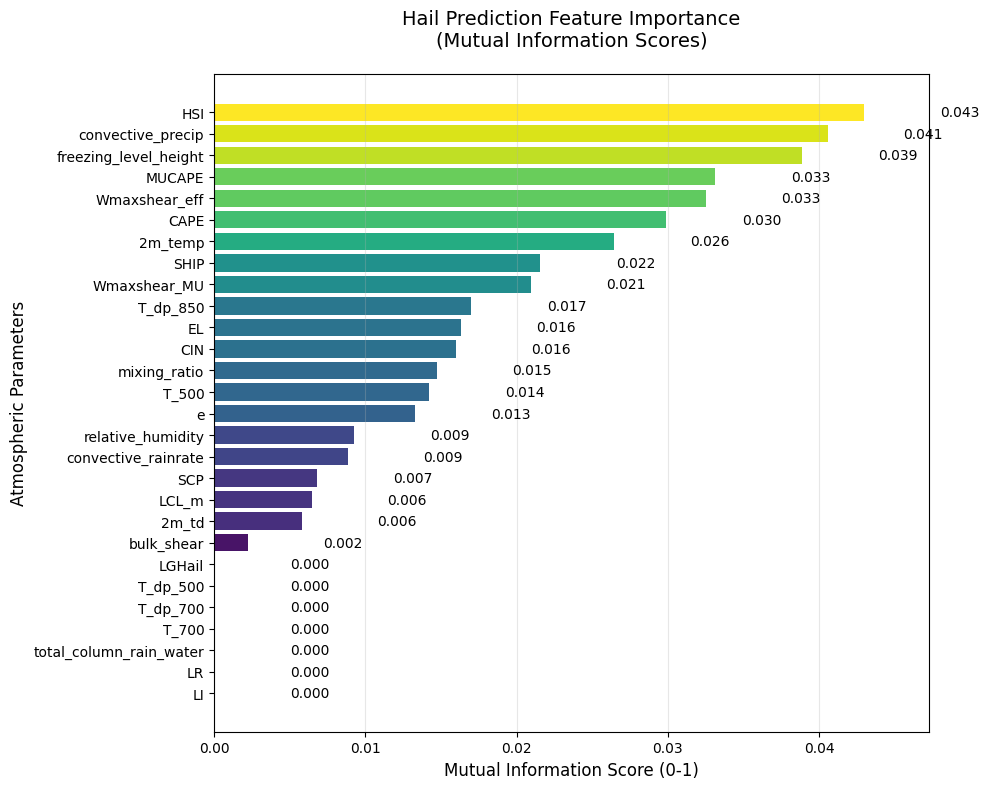


Top 10 most important features:
                  Feature  MI_Score
5                     HSI  0.042970
16      convective_precip  0.040558
15  freezing_level_height  0.038882
26                 MUCAPE  0.033143
25          Wmaxshear_eff  0.032511
2                    CAPE  0.029885
19                2m_temp  0.026438
22                   SHIP  0.021574
24           Wmaxshear_MU  0.020950
13               T_dp_850  0.017002


In [30]:
features = ["EL", "LCL_m", "CAPE", "CIN", "LI", "HSI", "bulk_shear", "LR", 
           "T_500", "T_700", "mixing_ratio", "T_dp_500", "T_dp_700", "T_dp_850", 
           "e", "freezing_level_height", "convective_precip", "convective_rainrate", 
           "total_column_rain_water","2m_temp", "2m_td", "LGHail", "SHIP", "SCP", "Wmaxshear_MU", "Wmaxshear_eff", "MUCAPE", "relative_humidity"]

valid_mask = balanced_df[features].notna().any() 
valid_features = balanced_df[features].columns[valid_mask].tolist()

print(f"Original features: {len(features)}") 
print(f"Features with valid values: {len(valid_features)}") 
print("Dropped features:", set(features) - set(valid_features))

df_imputed = balanced_df[valid_features].apply(lambda col: col.fillna(col.median()))

print(f"\nRemaining NaNs after imputation: {df_imputed.isna().sum().sum()}")

mi_scores = [] 

for feat in valid_features: # Extract the column as a 2D array 
    X_col = df_imputed[[feat]].values # Compute MI for this feature with the target
    mi = mutual_info_classif(X_col, balanced_df['hail_reported'], random_state=42, n_neighbors=5) 
    mi_scores.append(mi[0])

mi_df = pd.DataFrame({'Feature': valid_features, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=True)

plt.figure(figsize=(10, 8)) 
bars = plt.barh(mi_df['Feature'], mi_df['MI_Score'], color=plt.cm.viridis(mi_df['MI_Score'] / mi_df['MI_Score'].max())) 
for bar in bars: 
    width = bar.get_width() 
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center') 

plt.title('Hail Prediction Feature Importance\n(Mutual Information Scores)', fontsize=14, pad=20) 
plt.xlabel('Mutual Information Score (0-1)', fontsize=12) 
plt.ylabel('Atmospheric Parameters', fontsize=12) 
plt.grid(axis='x', alpha=0.3) 
plt.xlim([0, mi_df['MI_Score'].max() * 1.1]) 
plt.tight_layout() 

plt.savefig('hail_feature_importance.png', dpi=300, bbox_inches='tight') 
    
    
plt.show()

print("\nTop 10 most important features:") 
print(mi_df.tail(10).sort_values('MI_Score', ascending=False))



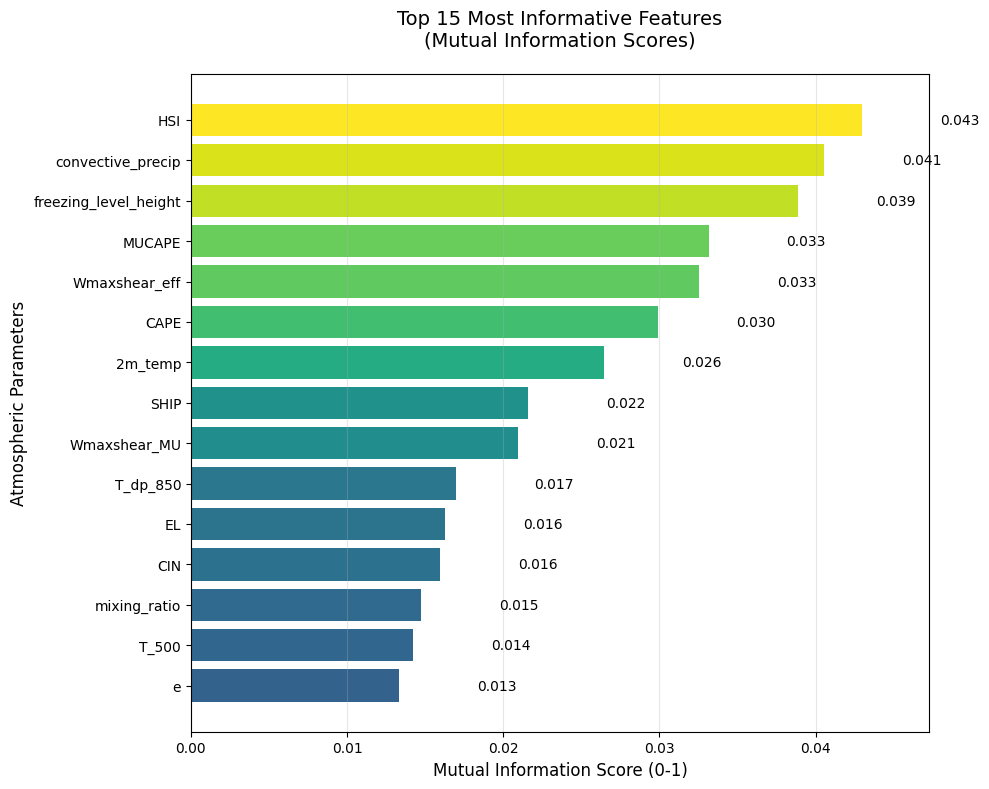

In [31]:
# Sort and select top 15
top_15_df = mi_df.sort_values('MI_Score', ascending=False).head(15).sort_values('MI_Score')

plt.figure(figsize=(10, 8))
bars = plt.barh(top_15_df['Feature'], top_15_df['MI_Score'],
                color=plt.cm.viridis(top_15_df['MI_Score'] / top_15_df['MI_Score'].max()))

# Add score labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

# Plot styling
plt.title('Top 15 Most Informative Features\n(Mutual Information Scores)', fontsize=14, pad=20)
plt.xlabel('Mutual Information Score (0-1)', fontsize=12)
plt.ylabel('Atmospheric Parameters', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.xlim([0, top_15_df['MI_Score'].max() * 1.1])
plt.tight_layout()

# Save + Show
plt.savefig('top15_hail_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [32]:


features = ['HSI', 'convective_precip', 'freezing_level_height', 'MUCAPE', 'Wmaxshear_eff', 'CAPE', '2m_temp', 'SHIP', 'Wmaxshear_MU', 'T_dp_850', 'EL', 'CIN', 'mixing_ratio', 'T_500', 'e', 'relative_humidity',
            'convective_precip', 'SCP', 'LCL_m', '2m_td']

X_raw = balanced_df[features].copy()

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_raw)

# X = balanced_df.drop('hail_reported', axis=1)
y = balanced_df['hail_reported']

hail_threshold = 0.1  
y_binary = (y >= hail_threshold).astype(int)  # 1 if hail, 0 otherwise

# Splitting your dataset into hail/no-hail classes
idx_class1 = np.where(y_binary == 1)[0]  # All hail reports
idx_class0 = np.where(y_binary == 0)[0]  # No hail


(print(f"Class 1 (hail) samples: {len(idx_class1)}"))
(print(f"Class 0 (no hail) samples: {len(idx_class0)}"))
(print(f"Total samples: {len(X_normalized)}"))


Class 1 (hail) samples: 30
Class 0 (no hail) samples: 150
Total samples: 180


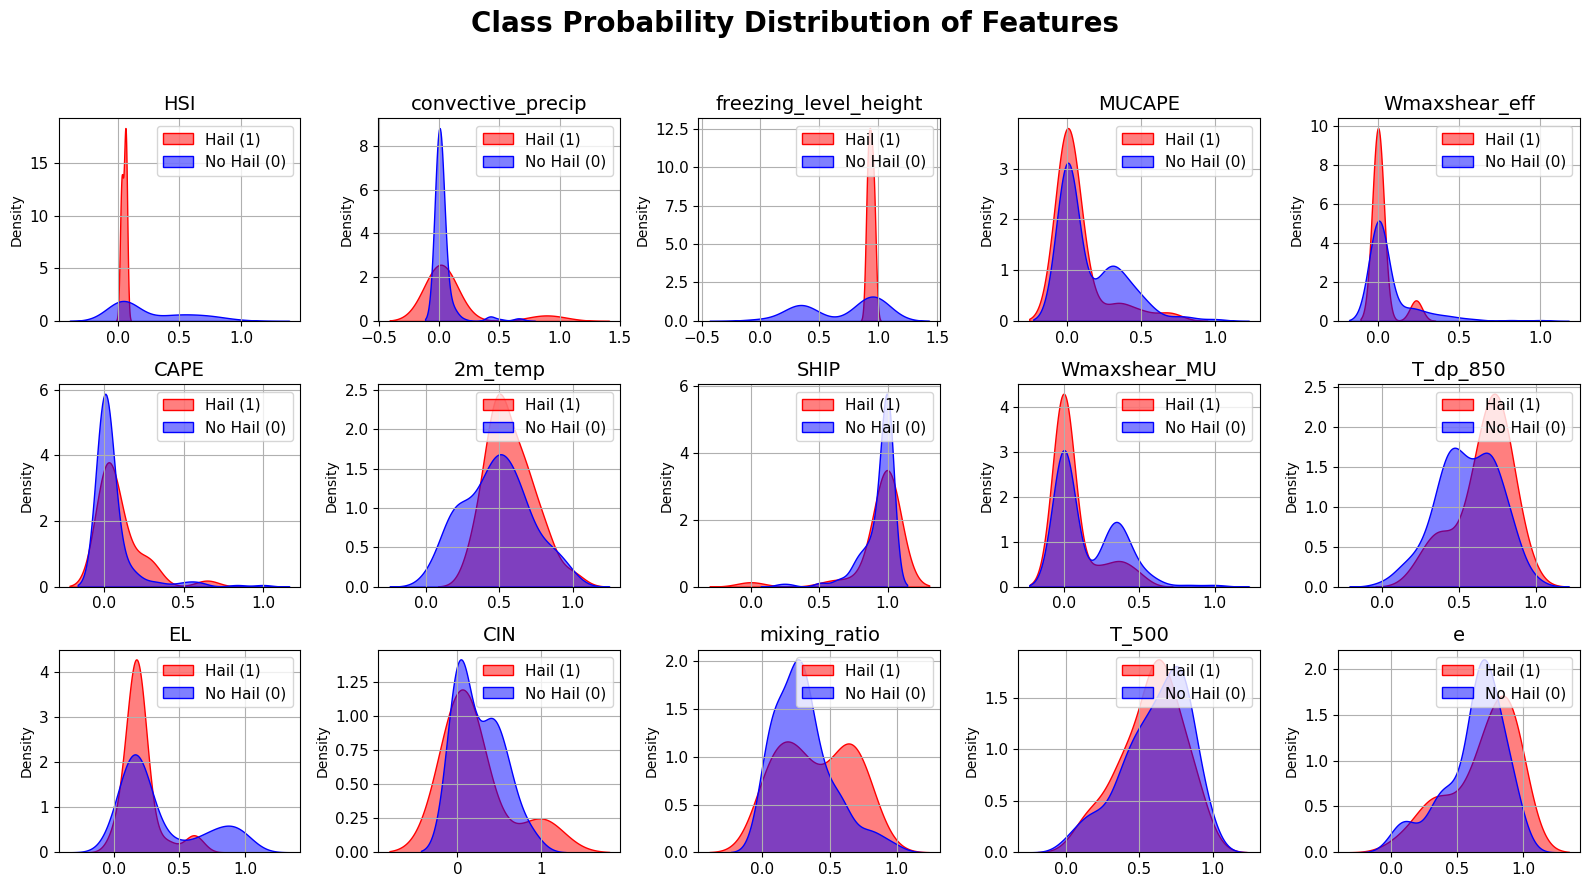

In [33]:
# Top 15 features 
features = ['HSI', 'convective_precip', 'freezing_level_height', 'MUCAPE', 'Wmaxshear_eff',
            'CAPE', '2m_temp', 'SHIP', 'Wmaxshear_MU', 'T_dp_850', 'EL', 'CIN',
            'mixing_ratio', 'T_500', 'e']

# Parameters
n_features = len(features)
n_samples = 5000
n_cols = 5
n_rows = math.ceil(n_features / n_cols)

# Set up subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

skipped_features = []

for ni in range(n_features):
    ax = axes[ni]

    values_class1 = X_normalized[idx_class1, ni]
    values_class0 = X_normalized[idx_class0, ni]

    values_class1 = values_class1[~np.isnan(values_class1)]
    values_class0 = values_class0[~np.isnan(values_class0)]

    if len(values_class1) == 0 or len(values_class0) == 0:
        ax.text(0.5, 0.5, f"{features[ni]}\n(No data)", ha="center", va="center", fontsize=12)
        ax.axis("off")
        skipped_features.append(features[ni])
        continue

    sample_class1 = np.random.choice(values_class1, size=min(n_samples, len(values_class1)), replace=False)
    sample_class0 = np.random.choice(values_class0, size=min(n_samples, len(values_class0)), replace=False)

    sns.kdeplot(sample_class1, ax=ax, color='red', fill=True, alpha=0.5, label='Hail (1)')
    sns.kdeplot(sample_class0, ax=ax, color='blue', fill=True, alpha=0.5, label='No Hail (0)')

    ax.set_title(features[ni], fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=11)
    ax.tick_params(axis='both', labelsize=11)

# Hide unused axes
for j in range(n_features, len(axes)):
    axes[j].axis("off")

plt.suptitle("Class Probability Distribution of Features", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("final_feature_probability_distributions.png", bbox_inches="tight", dpi=300)
plt.show()


# Import Lightning Data

In [34]:
# Load lightning data 
#data is already filtered for the bounding box
raw_lightning_df = pd.read_csv("filtered_lightning_data_central_alberta.csv")

raw_lightning_df.head()

,time,lat,lon,energy
0,2024-05-14 03:09:37.136266708,49.498646,-113.019440,1.802844e-13
1,2024-05-14 03:58:01.953155994,49.253310,-112.921890,1.642845e-13
2,2024-05-14 03:58:16.875337600,49.334377,-112.779050,1.112281e-12
3,2024-05-14 03:34:19.078359603,49.310574,-112.977425,5.212831e-13
4,2024-05-14 03:03:57.088199615,49.225883,-111.256020,4.352834e-13


In [35]:
# fix columns
raw_lightning_df['time'] = pd.to_datetime(raw_lightning_df['time'])  # Ensure 'time' is in datetime format
raw_lightning_df['date_hour'] = raw_lightning_df['time'].dt.floor('H')  # Round down to the nearest hour
raw_lightning_df['lat'] = raw_lightning_df['lat'].round(2)
raw_lightning_df['lon'] = raw_lightning_df['lon'].round(2)

# Group by time, lat, lon
lightning_df = raw_lightning_df.groupby(
    ['date_hour', 'lat', 'lon']
).agg(
    total_energy=('energy', 'sum'),
    strike_count=('energy', 'count'),
    avg_energy=('energy', 'mean')
).reset_index()

print(lightning_df.head())

   date_hour    lat     lon  total_energy  strike_count    avg_energy
0 2024-05-12  52.04 -114.75  1.812844e-13             1  1.812844e-13
1 2024-05-12  52.05 -114.81  3.495689e-13             2  1.747844e-13
2 2024-05-12  52.05 -114.80  1.615697e-13             2  8.078483e-14
3 2024-05-12  52.05 -114.73  7.432822e-13             1  7.432822e-13
4 2024-05-12  52.12 -114.83  3.032839e-13             1  3.032839e-13


/var/folders/cd/pz4_5yd54s330gxmz5wmp_hh0000gn/T/ipykernel_38817/2081605841.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  raw_lightning_df['date_hour'] = raw_lightning_df['time'].dt.floor('H')  # Round down to the nearest hour


In [36]:
# Extract the 'valid_time' and 'hail_reported' columns
hail_reported_df = balanced_df[['valid_time', 'hail_reported']].rename(columns={'valid_time': 'time'})

# Convert 'time' to datetime format
hail_reported_df['time'] = pd.to_datetime(hail_reported_df['time'])


# Display the first few rows to check the result
print(hail_reported_df.head())

                 time  hail_reported
0 2024-05-14 06:00:00              0
1 2024-10-24 10:00:00              0
2 2024-05-26 23:00:00              1
3 2024-05-21 04:00:00              0
4 2024-07-01 18:00:00              0


In [37]:
# Merge the lightning and hail data on the hourly time
hail_lightning_df = pd.merge(lightning_df, hail_reported_df, how='left', left_on='date_hour', right_on='time')

# Drop 'time' column as we have 'date_hour' now
hail_lightning_df = hail_lightning_df.drop(columns=['time'])

# Drop rows where 'hail_reported' is NaN
hail_lightning_df = hail_lightning_df.dropna(subset=['hail_reported'])

# Example of the first few rows of the combined dataframe
print(hail_lightning_df.head())


               date_hour    lat     lon  total_energy  strike_count  \
1340 2024-05-13 17:00:00  49.04 -111.77  2.402842e-13             1   
1341 2024-05-13 17:00:00  49.06 -111.94  3.195690e-13             2   
1342 2024-05-13 17:00:00  49.09 -111.26  6.328490e-14             1   
1343 2024-05-13 17:00:00  49.11 -111.14  5.045683e-13             2   
1344 2024-05-13 17:00:00  49.12 -111.15  6.222827e-13             1   

        avg_energy  hail_reported  
1340  2.402842e-13            0.0  
1341  1.597845e-13            0.0  
1342  6.328490e-14            0.0  
1343  2.522841e-13            0.0  
1344  6.222827e-13            0.0  


In [38]:
#filter for  suspcious lightning strikes

lightning_filtered_df = hail_lightning_df[
    ~((hail_lightning_df['strike_count'] >= 370) & (hail_lightning_df['strike_count'] <= 390))
]


# Train Model for Just Lightning Data

In [39]:
# Now split the cleaned data
X_lgt = lightning_filtered_df[['total_energy', 'strike_count', 'avg_energy']]  
y_lgt = lightning_filtered_df['hail_reported']

# Split the data into training and testing sets
X_train_lgt, X_test_lgt, y_train_lgt, y_test_lgt = train_test_split(X_lgt, y_lgt, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_lgt = scaler.fit_transform(X_train_lgt)
X_test_lgt = scaler.transform(X_test_lgt)

lgt_model = RandomForestClassifier(random_state=42)
lgt_model.fit(X_train_lgt, y_train_lgt)


# Train the model
lgt_model.fit(X_train_lgt, y_train_lgt)


RandomForestClassifier(random_state=42)

In [40]:
y_pred_lgt = lgt_model.predict(X_test_lgt)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_lgt, y_pred_lgt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_lgt, y_pred_lgt))
print("\nClassification Report:\n", classification_report(y_test_lgt, y_pred_lgt))


Accuracy: 0.5145631067961165

Confusion Matrix:
 [[269 286]
 [264 314]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.48      0.49       555
         1.0       0.52      0.54      0.53       578

    accuracy                           0.51      1133
   macro avg       0.51      0.51      0.51      1133
weighted avg       0.51      0.51      0.51      1133



In [41]:
lightning_filtered_df['combo'] = lightning_filtered_df['strike_count'].astype(str) + '-' + lightning_filtered_df['total_energy'].astype(str)

In [42]:
def compute_csi(y_true_lgt, y_pred_lgt):
    tn, fp, fn, tp = confusion_matrix(y_true_lgt, y_pred_lgt).ravel()
    return tp / (tp + fn + fp)

print(f"CSI: {compute_csi(y_test_lgt, y_pred_lgt):.3f}")


CSI: 0.363


In [43]:
y_pred_lgt = lgt_model.predict(X_test_lgt)

y_probs_lgt = lgt_model.predict_proba(X_test_lgt)[:, 1]

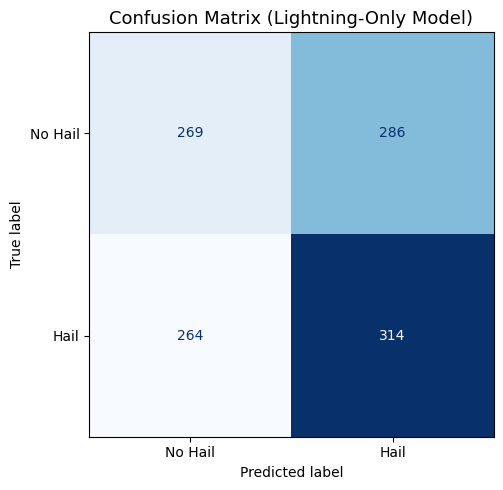

In [44]:
# Use your predictions and true labels for the lightning-only model
y_pred_lgt = lgt_model.predict(X_test_lgt)
y_true_lgt = y_test_lgt

# Compute and plot the confusion matrix
cm_lgt = confusion_matrix(y_true_lgt, y_pred_lgt)
labels = ['No Hail', 'Hail']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgt, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix (Lightning-Only Model)', fontsize=13)
plt.tight_layout()
plt.show()


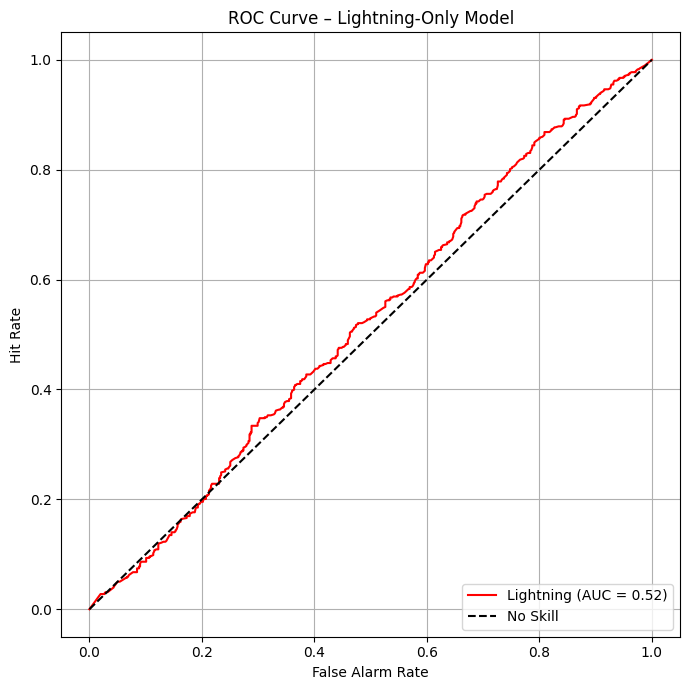

In [45]:
# Generate ROC curve data for Lightning-only model
fpr_lgt, tpr_lgt, thresholds_lgt = roc_curve(y_test_lgt, y_probs_lgt)
auc_lgt = roc_auc_score(y_test_lgt, y_probs_lgt)

# Plot
plt.figure(figsize=(7, 7))
plt.plot(fpr_lgt, tpr_lgt, color='red', label=f'Lightning (AUC = {auc_lgt:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')  # Diagonal reference line

# Labels and styling
plt.xlabel('False Alarm Rate')
plt.ylabel('Hit Rate')
plt.title('ROC Curve – Lightning-Only Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC_Lightning.png', dpi=300, bbox_inches='tight')
plt.show()


# Train model for Just ERAS5 model (TOP 5 Selected Features)

In [46]:
full_weather_df = filtered_ds.to_dataframe().reset_index()

In [47]:
# Format hail report coords
hail_coords = hail_df[['hour', 'latitude', 'longitude']].drop_duplicates()
hail_coords = hail_coords.rename(columns={'hour': 'valid_time'})

def round_to_grid(val, resolution=0.25):
    return round(val / resolution) * resolution

hail_coords['latitude'] = hail_coords['latitude'].apply(round_to_grid)
hail_coords['longitude'] = hail_coords['longitude'].apply(round_to_grid)
full_weather_df['latitude'] = full_weather_df['latitude'].apply(round_to_grid)
full_weather_df['longitude'] = full_weather_df['longitude'].apply(round_to_grid)


# Merge with ERA5
full_weather_df = full_weather_df.merge(
    hail_coords.assign(hail_reported=1),
    on=['valid_time', 'latitude', 'longitude'],
    how='left'
)

# Fill no-hail rows with 0
full_weather_df['hail_reported'] = full_weather_df['hail_reported'].fillna(0)

In [48]:
df_hail = full_weather_df[full_weather_df['hail_reported'] == 1]
df_no_hail = full_weather_df[full_weather_df['hail_reported'] == 0]

desired_ratio = 5 
n_samples = min(len(df_no_hail), len(df_hail) * desired_ratio)

df_no_hail_downsampled = resample(df_no_hail, n_samples=n_samples, random_state=42, replace=False)

model_balanced_df = pd.concat([df_hail, df_no_hail_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Final balanced dataset size:", model_balanced_df.shape)
print(model_balanced_df['hail_reported'].value_counts())


Final balanced dataset size: (20016, 46)
hail_reported
0.0    16680
1.0     3336
Name: count, dtype: int64


In [49]:
features = ['HSI', 'convective_precip', 'freezing_level_height', 'MUCAPE', 'Wmaxshear_eff']
X_era5 = model_balanced_df[features]
y_era5 = model_balanced_df['hail_reported']

In [50]:
#train the model
X_train_era5, X_test_era5, y_train_era5, y_test_era5 = train_test_split(X_era5, y_era5, test_size=0.2, random_state=42)

In [51]:
scaler = StandardScaler() 

X_train_scaled_era5 = scaler.fit_transform(X_train_era5) 
X_test_scaled_era5 = scaler.transform(X_test_era5)

In [52]:
era5_model = RandomForestClassifier(random_state=42) 
era5_model.fit(X_train_scaled_era5, y_train_era5)

RandomForestClassifier(random_state=42)

In [53]:

y_pred_era5 = era5_model.predict(X_test_scaled_era5) 
print(classification_report(y_test_era5, y_pred_era5)) 
print(confusion_matrix(y_test_era5, y_pred_era5))

y_probs_era5 = era5_model.predict_proba(X_test_era5)[:, 1]


              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      3325
         1.0       0.83      0.63      0.72       679

    accuracy                           0.92      4004
   macro avg       0.88      0.80      0.83      4004
weighted avg       0.91      0.92      0.91      4004

[[3239   86]
 [ 250  429]]


/Users/janesharai/miniconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [54]:
csi_era5 = 429 / (429 + 86 + 250)
csi_era5

0.5607843137254902

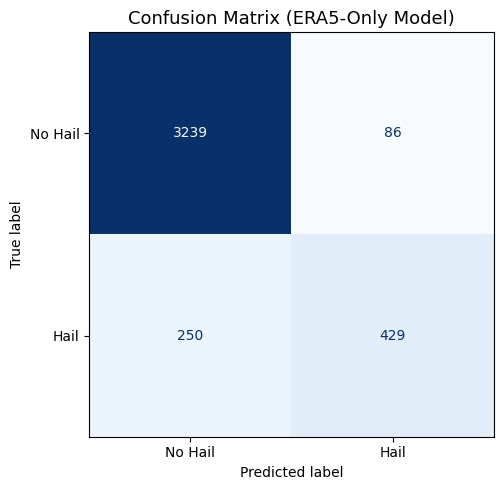

In [55]:
# Use predictions and true labels
y_pred_era5 = era5_model.predict(X_test_scaled_era5)
y_true_era5 = y_test_era5

# Compute and plot the confusion matrix
cm = confusion_matrix(y_true_era5, y_pred_era5)
labels = ['No Hail', 'Hail']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix (ERA5-Only Model)', fontsize=13)
plt.tight_layout()
plt.show()

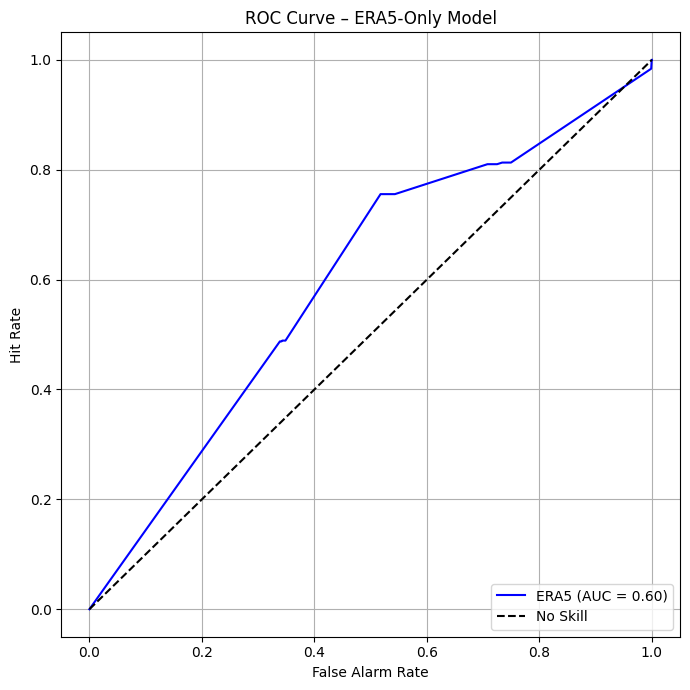

In [56]:
# Generate ROC curve data for ERA5-only
fpr_era5, tpr_era5, thresholds_era5 = roc_curve(y_test_era5, y_probs_era5)
auc_era5 = roc_auc_score(y_test_era5, y_probs_era5)

# Plot
plt.figure(figsize=(7, 7))
plt.plot(fpr_era5, tpr_era5, color='blue', label=f'ERA5 (AUC = {auc_era5:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')  # Diagonal reference line

# Labels and styling
plt.xlabel('False Alarm Rate')
plt.ylabel('Hit Rate')
plt.title('ROC Curve – ERA5-Only Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC_ERA5.png', dpi=300, bbox_inches='tight')
plt.show()


# Train Model for Lightning + ERA5 

In [57]:
# Convert both time columns to datetime
model_balanced_df['valid_time'] = pd.to_datetime(model_balanced_df['valid_time'])
lightning_df['date_hour'] = pd.to_datetime(lightning_df['date_hour'])

# Round lat/lon to match ERA5 resolution
model_balanced_df['lat'] = model_balanced_df['latitude'].round(2)
model_balanced_df['lon'] = model_balanced_df['longitude'].round(2)
lightning_df['lat'] = lightning_df['lat'].round(2)
lightning_df['lon'] = lightning_df['lon'].round(2)

# Rename time column in lightning data for merge compatibility
lightning_hourly = lightning_df.rename(columns={'date_hour': 'time'})

# Also rename ERA5 time to match
model_balanced_df = model_balanced_df.rename(columns={'valid_time': 'time'})

# Check before merge
print(lightning_hourly.columns.tolist())
print(model_balanced_df.columns.tolist())


['time', 'lat', 'lon', 'total_energy', 'strike_count', 'avg_energy']
['time', 'pressure_level', 'latitude', 'longitude', 'number', 'expver', 'geopotential_height', 'temp', 'u_wind', 'v_wind', 'specific_humidity', 'relative_humidity', 'CAPE', 'CIN', 'convective_precip', 'convective_rainrate', 'k_index', 'total_column_rain_water', 'precip_type', '2m_temp', '2m_td', 'mixing_ratio', 'T_dp_C', 'T_dp_K', 'e', 'MUCAPE', 'LCL_km', 'LCL_m', 'temp_at_LCL', 'LI', 'bulk_shear', 'EL', 'freezing_level_height', 'LR', 'HSI', 'LGHail', 'SHIP', 'SCP', 'Wmaxshear_MU', 'Wmaxshear_eff', 'T_500', 'T_700', 'T_dp_500', 'T_dp_700', 'T_dp_850', 'hail_reported', 'lat', 'lon']


In [58]:
lightning_eras5_data = model_balanced_df.merge(
    lightning_hourly,
    on=['time', 'lat', 'lon'],
    how='left'
)

# Fill missing lightning values with 0
lightning_eras5_data[['strike_count', 'total_energy', 'avg_energy']] = lightning_eras5_data[[
    'strike_count', 'total_energy', 'avg_energy'
]].fillna(0)

In [59]:

era5_features = ['HSI', 'convective_precip', 'freezing_level_height', 'MUCAPE', 'Wmaxshear_eff']
lightning_features = ['total_energy', 'strike_count', 'avg_energy']  

# Combine 
combined_features = era5_features + lightning_features


In [60]:
# train model 
X_combo = lightning_eras5_data[combined_features]
y_combo = lightning_eras5_data['hail_reported']


# Normalize 
X_scaled_combo = MinMaxScaler().fit_transform(X_combo)

# Split
X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(X_scaled_combo, y_combo, test_size=0.2, random_state=42)


In [61]:
combo_model = RandomForestClassifier(random_state=42)
combo_model.fit(X_train_combo, y_train_combo)


RandomForestClassifier(random_state=42)

In [62]:
y_pred_combo = combo_model.predict(X_test_combo)
y_prob_combo = combo_model.predict_proba(X_test_combo)[:, 1]  # For AUC and CSI


In [63]:
print("Confusion Matrix:\n", confusion_matrix(y_test_combo, y_pred_combo))
print("\nClassification Report:\n", classification_report(y_test_combo, y_pred_combo))
print(f"AUC: {roc_auc_score(y_test_combo, y_prob_combo):.3f}")


Confusion Matrix:
 [[3236   89]
 [ 227  452]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      3325
         1.0       0.84      0.67      0.74       679

    accuracy                           0.92      4004
   macro avg       0.88      0.82      0.85      4004
weighted avg       0.92      0.92      0.92      4004

AUC: 0.930


In [64]:

csi = compute_csi(y_test_combo, y_pred_combo)
print(f"CSI: {csi:.3f}")


CSI: 0.589


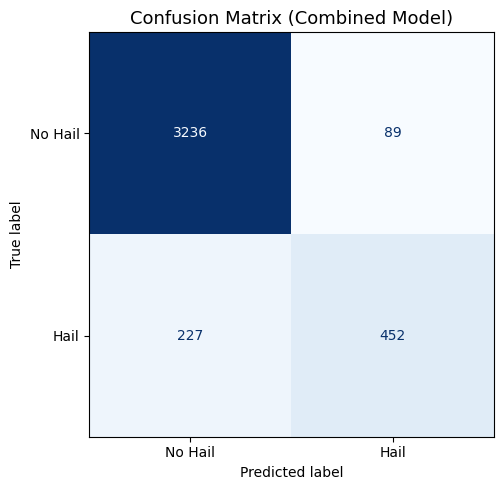

In [65]:
# Use predictions and true labels for the combined model
y_pred_combo = combo_model.predict(X_test_combo)
y_true_combo = y_test_combo

# Compute and plot the confusion matrix
cm_combo = confusion_matrix(y_true_combo, y_pred_combo)
labels = ['No Hail', 'Hail']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_combo, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix (Combined Model)', fontsize=13)
plt.tight_layout()
plt.show()


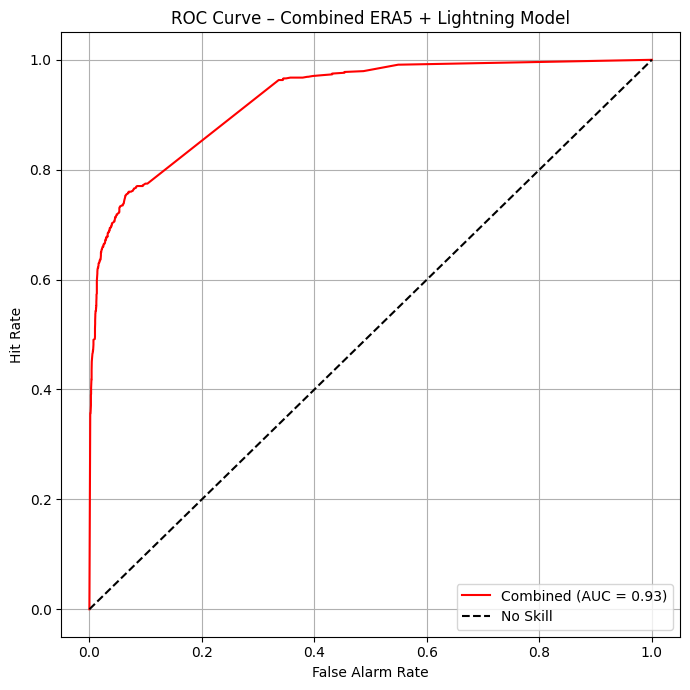

In [66]:
# Generate ROC data for the combined model
fpr_combo, tpr_combo, thresholds_combo = roc_curve(y_test_combo, y_prob_combo)
auc_combo = roc_auc_score(y_test_combo, y_prob_combo)

# Plot
plt.figure(figsize=(7, 7))
plt.plot(fpr_combo, tpr_combo, color='red', label=f'Combined (AUC = {auc_combo:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')  # Diagonal reference line

# Labels and styling
plt.xlabel('False Alarm Rate')
plt.ylabel('Hit Rate')
plt.title('ROC Curve – Combined ERA5 + Lightning Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC_Combined.png', dpi=300, bbox_inches='tight')
plt.show()


# creating combined ROC graph

AUC - ERA5: 0.5997546148139126
AUC - LGT: 0.5240344150378752
AUC - Combo: 0.930120367191912


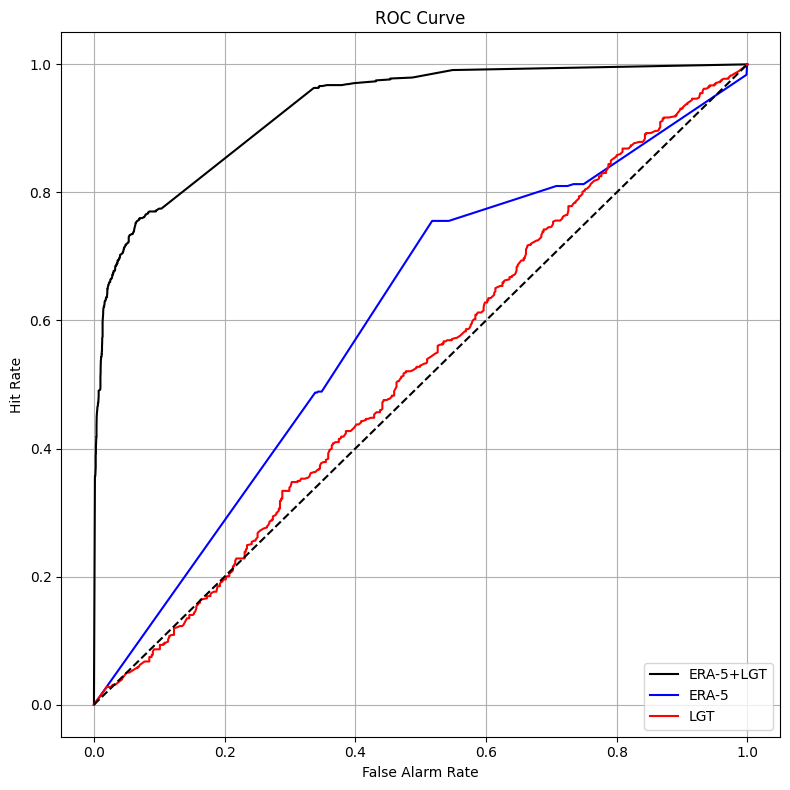

In [67]:
#create ROC graph

# Get FPR, TPR, thresholds for each
fpr_era5, tpr_era5, thr_era5 = roc_curve(y_test_era5, y_probs_era5)
fpr_lgt, tpr_lgt, thr_lgt = roc_curve(y_test_lgt, y_probs_lgt)
fpr_combo, tpr_combo, thr_combo = roc_curve(y_test_combo, y_prob_combo)

# Plot
plt.figure(figsize=(8, 8))
plt.plot(fpr_combo, tpr_combo, color='black', label='ERA-5+LGT')
plt.plot(fpr_era5, tpr_era5, color='blue', label='ERA-5')
plt.plot(fpr_lgt, tpr_lgt, color='red', label='LGT')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal

# Labels
plt.xlabel('False Alarm Rate')
plt.ylabel('Hit Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

print("AUC - ERA5:", roc_auc_score(y_test_era5, y_probs_era5))
print("AUC - LGT:", roc_auc_score(y_test_lgt, y_probs_lgt))
print("AUC - Combo:", roc_auc_score(y_test_combo, y_prob_combo))
plt.savefig('ROC.png', dpi=300, bbox_inches='tight')
plt.show()


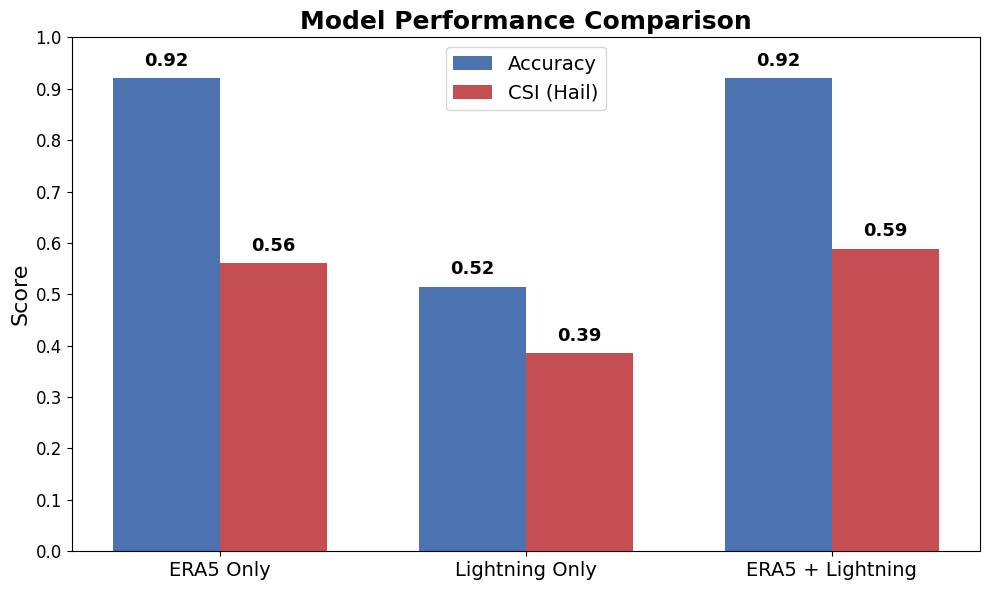

In [68]:

# Model names
models = ['ERA5 Only', 'Lightning Only', 'ERA5 + Lightning']

# Metrics
accuracy = [0.92, 0.515, 0.92]
csi_hail = [0.56, 0.386, 0.589]

# X locations
x = np.arange(len(models))
width = 0.35

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='#4C72B0')
bars2 = ax.bar(x + width/2, csi_hail, width, label='CSI (Hail)', color='#C44E52')

# Customize fonts and ticks
ax.set_ylabel('Score', fontsize=16)
ax.set_title('Model Performance Comparison', fontsize=18, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels([f'{t:.1f}' for t in np.arange(0, 1.1, 0.1)], fontsize=12)
ax.legend(fontsize=14)
ax.set_ylim(0, 1)

# Add values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=13, weight='bold')

plt.tight_layout()
plt.savefig("model_performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


In [69]:
#lightning only

# Select lightning-only features
lightning_features = ['total_energy', 'strike_count', 'avg_energy']
X = lightning_filtered_df[lightning_features]
y = lightning_filtered_df['hail_reported']

# Drop any rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define model
model = RandomForestClassifier(random_state=42)

# 5-fold cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5)

# Print results
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))


Cross-validation accuracy scores: [0.52956752 0.52826855 0.49734982 0.51325088 0.50353357]
Mean accuracy: 0.5143940693427812
Standard deviation: 0.012903476389756991


In [70]:

# Define your combined features

combined_features = ["HSI", "convective_precip", "freezing_level_height", "MUCAPE", "Wmaxshear_eff",
                     'total_energy', 'strike_count', 'avg_energy']

# Prepare input and target
X = lightning_eras5_data[combined_features]
y = lightning_eras5_data['hail_reported']

# Drop missing values
X = X.dropna()
y = y.loc[X.index]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define and evaluate model
model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(model, X_scaled, y, cv=5)

# Print results
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))


Cross-validation accuracy scores: [0.9435427  0.93719125 0.95130558 0.9435427  0.93785311]
Mean accuracy: 0.9426870646587642
Standard deviation: 0.005085549418448121


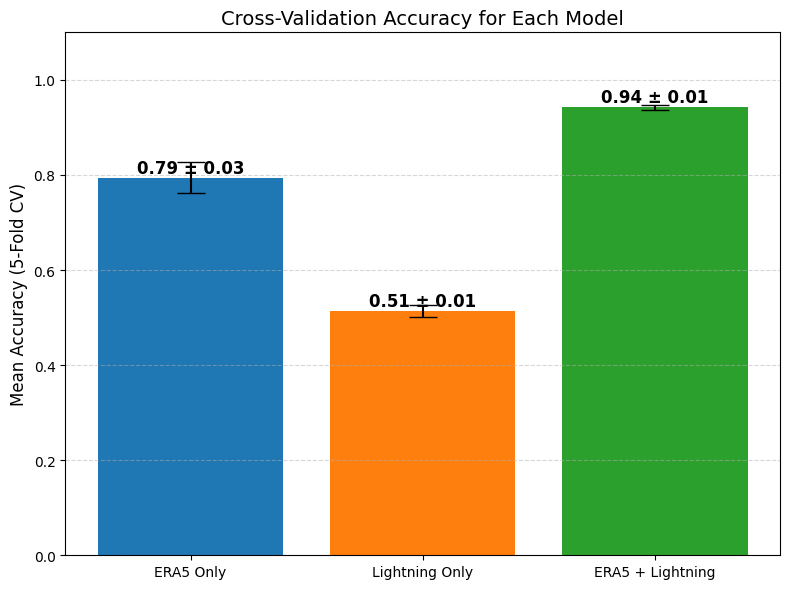

In [71]:
model_names = ['ERA5 Only', 'Lightning Only', 'ERA5 + Lightning']
mean_scores = [0.7944, 0.5144, 0.9427]  
std_devs = [0.0333, 0.0129, 0.0051]     

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, mean_scores, yerr=std_devs, capsize=10, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Annotate bars with exact values
for i, (score, std) in enumerate(zip(mean_scores, std_devs)):
    plt.text(i, score + 0.01, f"{score:.2f} ± {std:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.ylim(0, 1.1)
plt.ylabel('Mean Accuracy (5-Fold CV)', fontsize=12)
plt.title('Cross-Validation Accuracy for Each Model', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('cross_validation_summary.png', dpi=300)
plt.show()
